# Tutorial VIII - Police Districting

Applied Optimization with Julia

# Introduction

Imagine you’re the lead consultant for Hamburg’s police force
modernization project. The city is facing increasing response times in
certain districts, and the Chief of Police has hired you to optimize
their district boundaries. Your mission: redesign Hamburg’s police
districts to ensure rapid response times while meeting several critical
operational requirements.

Key Objectives:

-   Minimize average response time to incidents
-   Ensure every area has adequate police coverage
-   Enable efficient backup support between districts
-   Account for real-world constraints like traffic patterns

Throughout this tutorial, you’ll build this solution step-by-step,
starting with a basic model and gradually adding real-world constraints
that police departments face daily.

# 1. Modelling the P-Median Problem

Your first task is to fix a prototype model. It contains 6 critical
errors that are causing the model to fail. As the lead consultant, you
need to:

1.  Identify and fix these errors
2.  Document why each fix was necessary in a comment
3.  Validate that your solution makes sense

In this task it is **not yet necessary** to include contiguity and
compactness constraints! If the model takes too long on your machine,
you can set the **relative gap to 10% or decrease the time limit**.

To execute the code, several files are provided, which contain the
Euclidean distance between the BAs, the driving time between BAs, the
number of incidents per BA, and the hexagonal shapes (a `.shp` file and
a `.dbf` file - you need both!).

------------------------------------------------------------------------

## Loading Data and Packages

We start by loading the new `Shapefile` package. **No mistakes here!**

In [1]:
import Pkg
Pkg.add("Shapefile")

    Updating registry at `C:\Users\Ozan Arif Yavuz\.julia\registries\General.toml`
   Resolving package versions...
   Installed Extents ──────── v0.1.6
   Installed DBFTables ────── v1.2.7
   Installed GeoFormatTypes ─ v0.4.5
   Installed Shapefile ────── v0.13.3
   Installed GeoInterface ─── v1.6.0
    Updating `C:\Users\Ozan Arif Yavuz\OneDrive\Masaüstü\Applied-Optimization\applied-optimization\Project.toml`
  [8e980c4a] + Shapefile v0.13.3
    Updating `C:\Users\Ozan Arif Yavuz\OneDrive\Masaüstü\Applied-Optimization\applied-optimization\Manifest.toml`
  [75c7ada1] + DBFTables v1.2.7
  [411431e0] + Extents v0.1.6
  [68eda718] + GeoFormatTypes v0.4.5
  [cf35fbd7] + GeoInterface v1.6.0
  [8e980c4a] + Shapefile v0.13.3
Precompiling packages...
  15862.7 ms  ✓ Extents
   8440.0 ms  ✓ DBFTables
  15955.8 ms  ✓ GeoFormatTypes
   3091.0 ms  ✓ GeoInterface
   1798.7 ms  ✓ GeoInterface → GeoInterfaceRecipesBaseExt
   4423.0 ms  ✓ Shapefile
   1855.3 ms  ✓ Shapefile → ShapefileRecipesBaseExt


We then load the required packages. If you have not installed them yet,
you can do so by modifying the code chunk above to include the missing
packages. **Still no mistakes!**

In [2]:
using JuMP, HiGHS
using DelimitedFiles
using Shapefile
using DataFrames
using Plots

We then define the number of departments, load the data into scope and
define the number of departments and the weighted driving times. Make
sure to use the correct path to the data files - it should be relative
to the location notebook file in a folder called `data`. **Again, no
mistakes!**

In [3]:
# Load the data into scope
file_directory = "$(@__DIR__)/data"
euclidianDistances = readdlm("$file_directory/euclidianDistances0510.csv",'\t')
drivingTimes = readdlm("$file_directory/drivingTimes0510.csv",'\t')
incidentWeights = vec(readdlm("$file_directory/incidentWeights0510.csv",'\t'))

# Load the Shapefile for plotting
hexshape = DataFrame(Shapefile.Table("$file_directory/grid0510.shp"))
sort!(hexshape, :id)

# Define the number of departments
p = 10

# Define the weighted driving times
weightedDriving = drivingTimes .* transpose(incidentWeights)

510×510 Matrix{Float64}:
   10.0    88.66    734.08   484.88   327.9  …  0.0  3520.26  4026.38  4456.5
   68.2    13.0     352.16   306.82   235.8     0.0  3468.6   3968.42  4393.5
  118.4    73.84     62.0    164.72   162.3     0.0  3376.35  3864.92  4280.5
  167.2   137.54    352.16    29.0     78.9     0.0  3343.96  3828.58  4241.0
  218.6   204.36    670.84   152.54    15.0     0.0  3314.44  3786.72  4205.0
  279.2   283.14   1046.56   328.28    90.9  …  0.0  3343.14  3818.92  4240.5
  336.8   358.02   1403.68   495.32   177.3     0.0  3272.21  3726.46  4153.5
  388.6   425.36   1724.84   645.54   255.0     0.0  3234.08  3651.02  4092.0
  450.4   505.7    2108.0    824.18   347.4     0.0  3184.06  3594.9   4031.5
  516.6   591.76   2518.44  1016.74   447.0     0.0  3152.49  3559.48  3993.0
  585.8   681.72   2947.48  1217.42   550.8  …  0.0  3153.72  3544.76  3976.5
  635.6   746.46   3256.24  1361.26   625.2     0.0  3045.89  3423.78  3845.5
  679.6   803.66   3529.04  1489.44   6

------------------------------------------------------------------------

## Fixing the Mistakes

From here on, the code contains **6 mistakes** you need to correct in
order to solve the model. **Mistakes can be anything so be careful!**

In [4]:
# MISTAKES BELOW

# Prepare the model instance
pMedianModel = Model(HiGHS.Optimizer)
set_attribute(pMedianModel, "presolve", "on")
# The first fix: The model name wasn't correct inside the set_attribute() function.
set_attribute(pMedianModel, "time_limit", 120.0)
set_attribute(pMedianModel, "mip_rel_gap", 0.0)

# Define the range of the problem instance
# The second fix: The range for the basic areas was 1:2, and it's not correct for the purpose of our model.
rangeBAs = 1:size(incidentWeights, 1)
rangeDepartments = unique(rand(1:size(incidentWeights,1), 100))  # Ensure unique departments (This line is correct!)

# Define variable
# The third fix: The i and j dimensions of the variable are the same - rangeDepartments. However, j should represent the basic areas.
@variable(pMedianModel, X[i = rangeDepartments,j = rangeBAs], Bin)

# Define objective function
# The fourth mistake is about the logic of the objective function. Our objective function aims to minimize total driving time.
@objective(pMedianModel, Min,
    sum(weightedDriving[i,j]* X[i,j] for i in rangeDepartments, j in rangeBAs)
    )

# Define the constraints
# The fifth fix: The allocation constraint can't force us nothing to be assigned. It should be equal to 1.
@constraint(pMedianModel,
    eachAllocated[j=rangeBAs],
    sum(X[i,j] for i in rangeDepartments) == 1
    )

@constraint(pMedianModel,
    pLocations,
    sum(X[i,i] for i in rangeDepartments) == p
    )

# The sixth fix: The necessary department constraint should be written correctly - multiplying the X[i, j] by 2 isn't correct behaviour.
@constraint(pMedianModel,
    departmentNecessary[i=rangeDepartments,j=rangeBAs],
    X[i,j] <= X[i,i]
    )

# Start optimization
optimize!(pMedianModel)

# MISTAKES ABOVE

Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 45901 rows; 45390 cols; 136081 nonzeros; 45390 integer variables (45390 binary)
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [5e-01, 4e+04]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 1e+01]
Presolving model
45812 rows, 45390 cols, 136081 nonzeros  0s
45812 rows, 45390 cols, 136081 nonzeros  0s
Presolve reductions: rows 45812(-89); columns 45390(-0); nonzeros 136081(-0) 

Solving MIP model with:
   45812 rows
   45390 cols (45390 binary, 0 integer, 0 implied int., 0 continuous, 0 domain fixed)
   136081 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial

We then check the solution. **No mistakes here, as all mistakes are in
the code in the cell above!**

In [5]:
# Function to print the model status
function print_model_status(model)
    begin
        println()
    if termination_status(pMedianModel) == OPTIMAL
        println("Great, the solution is optimal.")
        println("The relative gap is $(relative_gap(pMedianModel))")
        println("The solve time (in seconds) is $(solve_time(pMedianModel))")
    elseif termination_status(pMedianModel) == TIME_LIMIT && has_values(pMedianModel)
        println("Solution is suboptimal due to a time limit, but a primal solution is available")
    else
        error("The model was not solved correctly.")
    end
        println("The objective value is ", objective_value(pMedianModel))
    end
end

print_model_status (generic function with 1 method)

In [6]:
print_model_status(pMedianModel)
@assert termination_status(pMedianModel) == OPTIMAL || (termination_status(pMedianModel) == TIME_LIMIT && has_values(pMedianModel)) "Unfortunate, the model was not solved correctly. Have you corrected all mistakes?"
println("Great, the model was solved correctly.")


Great, the solution is optimal.
The relative gap is 0.0
The solve time (in seconds) is 4.976093053817749
The objective value is 325997.3
Great, the model was solved correctly.


------------------------------------------------------------------------

## Visualizing the Results

The following code then builds and uses a function to plot the results.

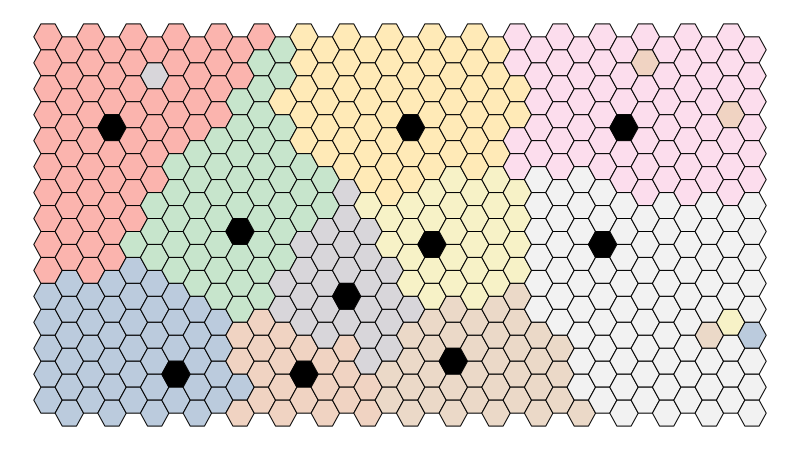

In [7]:
function visualize_departments(hexshape, X, p)
    # Convert solution matrix to regular Matrix
    allAssignments = Matrix(value.(X))

    # Find assignments where value > 0.5 (accounting for potential floating-point imprecision)
    assignments = findall(allAssignments .> 0.5)

    # Create copy of hexshape to avoid modifying original
    plot_data = copy(hexshape)

    # Assign departments and initialize colors
    plot_data.department = rangeDepartments[map(x->x[1], assignments)]
    plot_data.color = fill(RGB(0/255, 0/255, 0/255), nrow(plot_data))

    # Get unique department locations and create color mapping
    department_locations = unique(rangeDepartments[map(x->x[1], assignments)])
    color_palette = cgrad(:Pastel1_9, p, categorical=true)
    color_dict = Dict(department_locations[i] => color_palette[i] for i in 1:p)

    # Color non-department locations
    for hex in eachrow(plot_data)
        if hex.id in department_locations
            hex.color = RGB(0/255, 0/255, 0/255)
        else
            hex.color = color_dict[hex.department]
        end
    end

    # Create and return plot
    return plot(
        plot_data.geometry,
        color=plot_data.color',
        legend=false,
        axis=false,
        ticks=false,
        size=(800,450)
    )
end

# Plot the results
plot_area = visualize_departments(hexshape, X, p)

------------------------------------------------------------------------

# 2. Ensuring District Connectivity

The Police Chief has identified a critical flaw in the initial model:
some police units would need to drive through other districts to reach
parts of their own district! This creates jurisdictional issues and
slower response times.

Your challenge:

-   Implement contiguity constraints to ensure each district is fully
    connected
-   Compare response times before and after adding these constraints
-   Visualize the impact of your changes on the district map

## Conditional Constraints

Before we start, we will quickly repeat some basic concepts on
constraints and conditions in JuMP. You can add conditions to
constraints by using the `;` operator. This is useful if you want to add
a constraint only under certain conditions. In the example below, the
constraint is only active if the Euclidean distance between two BAs is
less than 1.5.

In [9]:
@constraint(model,
    conditionalConstraint[
        i=rangeDepartments,
        j=rangeBAs;
        euclidianDistances[i,j] < 1.5
        ],
    X[i,j] == 1
    )

Furthermore,we can use conditions within constraints by using the `for`
keyword. For example, in the constraint below, the sum is only taken
over the BAs that are within 1.5 units of BA $i$.

In [10]:
@constraint(model,
    conditionalConstraint2[i=rangeDepartments],
    sum(X[i,j] for j in rangeBAs if euclidianDistances[i,j] < 1.5) >= 1
    )

------------------------------------------------------------------------

## Extending the Model

Now, we can start to extend the model. Add the contiguity constraint
from the lecture to the model.

> **Important**
>
> Take a careful look at the Euclidean distances, as you can use them to
> determine if two BAs are adjacent to each other. If the distance
> between two BAs is less than 1.5, then the BAs are adjacent to each
> other. You can use this information to define the new constraint.

In [11]:
# YOUR CODE BELOW

Solve the model again, this time with the contiguity constraint.

In [12]:
# YOUR CODE BELOW

The following code prints the model status and visualizes the districts.
If your implementation is correct, the districts should be contiguous
and the model should have reached optimality or found a feasible
solution before hitting the time limit.

In [13]:
print_model_status(pMedianModel)
display(visualize_departments(hexshape, X, p))

------------------------------------------------------------------------

## Compute the Gap

Based on your results, what is the gap between the solution in the
previous task and this task? Write a comment answering the question in
cell below. You can also use the cell, to compute the gap based on the
objective values.

In [14]:
#=



=#

> **Tip**
>
> If you computer cannot determine the optimal solution, you can just
> use the best solutions you found after both runs to compute the gap.

------------------------------------------------------------------------

# 3. Emergency Response Time Guarantees

Hamburg’s City Council has mandated that high-priority emergencies must
receive a response within 20 minutes. Your previous model doesn’t
guarantee this! Your task: Implement maximum response time constraints.

Extend your model by an additional parameter `max_driving_time = 20` to
ensure that no allocation with a driving time $d_{i,j}$ higher than
`max_driving_time` minutes from $i$ to $j$ is possible.

In [15]:
# YOUR CODE BELOW

> **Tip**
>
> Don’t confuse the `weightedDriving` matrix with the `drivingTimes`
> matrix! The `weightedDriving` matrix contains the weighted driving
> times, while the `drivingTimes` matrix contains the driving times.

Again, solve the model.

In [16]:
# YOUR CODE BELOW

The following code prints the model status and visualizes the districts.
If your implementation is correct, the districts with previously longer
driving times should have shrinked. Furthermore, the model should have
reached optimality or found a feasible solution before hitting the time
limit.

In [17]:
print_model_status(pMedianModel)
display(visualize_departments(hexshape, X, p))

------------------------------------------------------------------------

# 4. Planning for Peak Demand

During major events or crime waves, districts need backup support from
neighboring stations. The Police Union has emphasized this as a critical
safety requirement for their officers. Your task: Design constraints
ensuring each district has backup support within 20 minutes of the
driving time.

In [18]:
# YOUR CODE BELOW

> **Tip**
>
> This is a rather complicated task, so don’t worry if you cannot find
> the correct restriction. Try to come up with something or describe
> your thoughts in comments if you do not find the correct restriction
> or a way to implement it. If you are not sure, it often helps to start
> on paper and to draw the districts and the BAs to find a way to
> implement it.

In case you came up with a solution, solve the model to optimize the
layout of the districts.

In [19]:
# YOUR CODE BELOW

If your implementation is correct, the districts are contiguous and
distributed across the city. In addition, the model should have reached
optimality or found a feasible solution before hitting the time limit.

In [20]:
print_model_status(pMedianModel)
display(visualize_departments(hexshape, X, p))

------------------------------------------------------------------------

# Solutions

You will likely find solutions to most exercises online. However, I
strongly encourage you to work on these exercises independently without
searching explicitly for the exact answers to the exercises.
Understanding someone else’s solution is very different from developing
your own. Use the lecture notes and try to solve the exercises on your
own. This approach will significantly enhance your learning and
problem-solving skills.

Remember, the goal is not just to complete the exercises, but to
understand the concepts and improve your programming abilities. If you
encounter difficulties, review the lecture materials, experiment with
different approaches, and don’t hesitate to ask for clarification during
class discussions.